In [1]:
import os
import datetime
import imageio

import numpy as np

from PIL import Image
import cv2
from skimage import io
from tqdm.auto import tqdm
from xml.etree import ElementTree
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models, datasets
from torchsummary import summary
import json
import time

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

class LandmarksDataset(Dataset):
    def __init__(self, train):
        self.root_dir = f'./../data/landmarks/{"train" if train else "test"}/statue/'
        self.root_landmarks = f'../data/landmarks/{"train" if train else "test"}/statues128landmarks.json'
        with open(self.root_landmarks) as fp:
            self.landmark_points = json.load(fp)
        self.image_paths = []
        self.landmarks = []
        self.train = train
        filenames = os.listdir(self.root_dir)
        filenames = [filename for filename in filenames if filename.split('.')[1] in ('jpg', 'jpeg', 'png')]
        filenames = sorted(filenames, key=lambda fn: int(fn.split('.')[0]))
        
        for filename in filenames:
            path_to_img = os.path.join(self.root_dir, filename)
            self.image_paths.append(path_to_img)
            landmark = []
            for num in range(68):
                x_coordinate = int(self.landmark_points[filename][str(num)]['x'])
                y_coordinate = int(self.landmark_points[filename][str(num)]['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')
        assert len(self.image_paths) == len(self.landmarks)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        #image = io.imread(self.image_paths[index], as_gray=True)
        image = cv2.imread(self.image_paths[index], cv2.IMREAD_GRAYSCALE)
        #print(self.image_paths[index])
        img_tensor = transform(image)
        landmarks = self.landmarks[index]
        landmarks = landmarks - 0.5
        return img_tensor, landmarks

In [3]:
def visualize_image(image, landmarks):
    plt.figure(figsize = (2, 2))
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 3, c = 'black')
    plt.axis('off')
    plt.show()
    
def visualize_batch(images_list, landmarks_list, size = 14, shape = (6, 6), title = None, save = None):
    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
    for ax, image, landmarks in zip(grid, images_list, landmarks_list):
        landmarks = landmarks.view(-1, 2)
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()

In [25]:
train_dataset = LandmarksDataset(train = True)
test_dataset = LandmarksDataset(train = False)

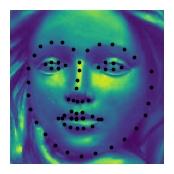

torch.Size([1, 128, 128])


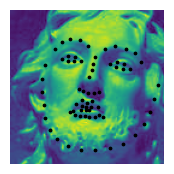

torch.Size([1, 128, 128])


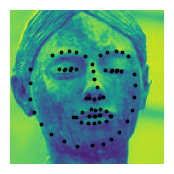

torch.Size([1, 128, 128])


In [5]:
for i in range(3):
    image1, landmarks1 = train_dataset[i+200]
    visualize_image(image1.permute(1, 2, 0), landmarks1)
    print(image1.shape)

In [6]:
len_train_set = len(train_dataset)
len_test_set = len(test_dataset)

print("The length of Train set is {}".format(len_train_set))
print("The length of Test set is {}".format(len_test_set))

#train_dataset , valid_dataset,  = torch.utils.data.random_split(train_dataset , [len_train_set, len_valid_set])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

The length of Train set is 748
The length of Test set is 130


In [7]:
images, landmarks = next(iter(train_loader))

In [8]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

torch.Size([1, 128, 128])

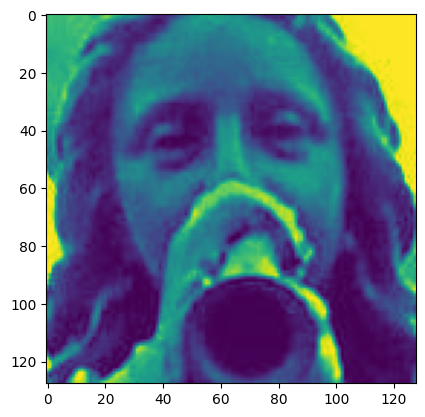

In [9]:
plt.imshow(images[0].permute(1, 2, 0))
images[0].shape

In [10]:
images.shape

torch.Size([64, 1, 128, 128])

In [11]:
Network()(images)

tensor([[-0.0655, -0.2852, -0.1917,  ...,  0.4634,  0.0638,  0.9366],
        [-0.1990, -0.1708, -0.1872,  ...,  0.2653, -0.1021,  0.7558],
        [-0.4328, -0.2097, -0.0454,  ...,  0.7386,  0.0721,  1.1944],
        ...,
        [-0.0832, -0.1017, -0.2721,  ...,  0.3752,  0.1883,  0.8057],
        [-0.1823,  0.0341, -0.1508,  ...,  0.3068,  0.1776,  0.7256],
        [-0.2818, -0.0992, -0.2241,  ...,  0.4169,  0.2936,  0.9160]],
       grad_fn=<AddmmBackward0>)

In [12]:
import sys
def log_step(step, total_step, loss, operation, logfile_path):
    with open(logfile_path, 'a') as logfile:
        if operation == 'train':
            print("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        else:
            print("Valid Steps: %d/%d  Loss: %.4f \n" % (step, total_step, loss))

def log_info(logfile_path, msg):
    with open(logfile_path, 'a') as logfile:
        logfile.write(msg)

In [13]:
torch.autograd.set_detect_anomaly(True)
network = Network()
train_id = datetime.datetime.now().strftime('resnet18_landmarkdetector_%Y-%m-%d_%H:%M:%S')
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 128

start_time = time.time()
logfile_path = f'../training_marks/{train_id}.log'
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        images = images
        landmarks = landmarks.view(landmarks.size(0),-1)
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        log_info(logfile_path, "Train Steps: %d/%d  Loss: %.4f \n" % (step, len(train_loader), running_loss))
    network.eval()
    with torch.no_grad():
        
        for step in range(1,len(test_loader)+1):
            
            images, landmarks = next(iter(test_loader))
        
            images = images
            landmarks = landmarks.view(landmarks.size(0),-1)
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step
            log_info(logfile_path, "Valid Steps: %d/%d  Loss: %.4f \n" % (step, len(test_loader), running_loss))
    
    loss_train /= len(train_loader)
    loss_valid /= len(test_loader)
    
    log_info(logfile_path, '--------------------------------------------------\n')
    log_info(logfile_path, 'Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}\n'.format(epoch, loss_train, loss_valid))
    log_info(logfile_path, '--------------------------------------------------\n')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        mark_id = ''
        torch.save(network.state_dict(), f'../training_marks/{train_id}.pth') 
        log_info(logfile_path, "Minimum Validation Loss of {:.4f} at epoch {}/{}\n".format(loss_min, epoch, num_epochs))
        log_info(logfile_path, 'Model Saved\n\n')
     
log_info(logfile_path, 'Training Complete\n')
log_info(logfile_path, "Total Elapsed Time : {} s\n".format(time.time()-start_time))

KeyboardInterrupt: 

Ground truth


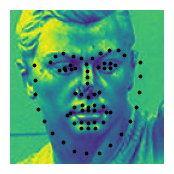


Predicted landmarks
torch.Size([68, 2])


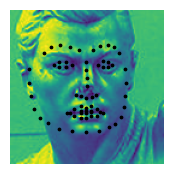

torch.Size([68, 2])


In [23]:
images, real_landmarks = next(iter(train_loader))
predicted_landmarks = network(images)
predicted_landmarks = predicted_landmarks.detach()
print('Ground truth')
visualize_image(images[0].permute(1, 2, 0), real_landmarks[0])

print('\nPredicted landmarks')

image0 = images[0]
predicted_landmark0 = torch.reshape(predicted_landmarks[0], (68, 2))
print(real_landmarks[0].shape)
visualize_image(image0.permute(1, 2, 0), predicted_landmark0)
print(torch.reshape(predicted_landmarks[0], (68, 2)).shape)


In [15]:
real_landmarks[0]

tensor([[ 22.5000,  60.5000],
        [ 25.5000,  71.5000],
        [ 29.5000,  84.5000],
        [ 36.5000,  96.5000],
        [ 46.5000, 104.5000],
        [ 55.5000, 111.5000],
        [ 65.5000, 119.5000],
        [ 74.5000, 124.5000],
        [ 82.5000, 124.5000],
        [ 90.5000, 118.5000],
        [ 98.5000, 110.5000],
        [104.5000,  99.5000],
        [109.5000,  86.5000],
        [113.5000,  72.5000],
        [113.5000,  58.5000],
        [109.5000,  44.5000],
        [105.5000,  31.5000],
        [ 34.5000,  40.5000],
        [ 36.5000,  38.5000],
        [ 39.5000,  37.5000],
        [ 42.5000,  35.5000],
        [ 45.5000,  37.5000],
        [ 61.5000,  33.5000],
        [ 65.5000,  26.5000],
        [ 71.5000,  22.5000],
        [ 78.5000,  20.5000],
        [ 86.5000,  22.5000],
        [ 54.5000,  47.5000],
        [ 56.5000,  54.5000],
        [ 57.5000,  61.5000],
        [ 59.5000,  68.5000],
        [ 56.5000,  77.5000],
        [ 60.5000,  78.5000],
        [ 